In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import requests
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Specify the start and end dates
start_date = "2025-05-05"
end_date = datetime.now().strftime('%Y-%m-%d')

# Collect Goldman stock data from the specified date range
GS_stock = yf.Ticker("GS")
stock_data = GS_stock.history(start=start_date, end=end_date)
stock_data.reset_index(inplace=True)
stock_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2025-05-05 00:00:00-04:00,555.590608,563.749949,554.734888,556.784668,2197200,0.0,0.0
1,2025-05-06 00:00:00-04:00,546.874054,554.675195,544.346674,546.635254,2902500,0.0,0.0
2,2025-05-07 00:00:00-04:00,547.481076,552.625417,545.023296,549.182556,1954900,0.0,0.0
3,2025-05-08 00:00:00-04:00,556.048345,569.322147,555.441385,562.894226,1994600,0.0,0.0
4,2025-05-09 00:00:00-04:00,567.421632,569.262432,562.973832,564.287231,1522500,0.0,0.0


In [3]:
api_key =os.getenv("NEWS_API_KEY")


url = 'https://newsapi.org/v2/everything'
params = {
    'q': 'Goldman Sachs',
    'from': (datetime.now() - timedelta(days=28)).strftime('%Y-%m-%d'),  # Get articles from the last 30 days
    'sortBy': 'relevancy',
    'apiKey': api_key,
    'pageSize': 100,  # Maximum number of results per page
    'language': 'en'
}

# Make the request
response = requests.get(url, params=params)
data = response.json()

# Check for errors
if data['status'] != 'ok':
    raise Exception(f"NewsAPI error: {data['message']}")

# Extract articles
articles = data['articles']

# Convert to DataFrame
news_data = pd.DataFrame(articles)
news_data = news_data[['publishedAt', 'title']]
news_data.columns = ['date', 'headline']

In [4]:
news_data

,date,headline
0,2025-06-27T09:02:56Z,Tariffs won't fix America's manufacturing prob...
1,2025-07-17T15:10:48Z,Goldman carves new career path for junior bank...
2,2025-06-26T20:22:54Z,Wall Street intern survival guide: how to surv...
3,2025-07-16T14:18:05Z,Goldman Highlights Two Chip Stocks To Watch Be...
4,2025-06-23T21:45:56Z,Goldman Sachs Makes a Huge AI Bet
...,...,...
95,2025-06-27T18:45:30Z,"The Goldman Sachs Group, Inc. (GS) Is Doing Gr..."
96,2025-06-27T18:59:24Z,Dollar General Corporation (DG)’s Goldman Sach...
97,2025-07-02T21:35:34Z,"Barclays names Anne Marie Darling, who retired..."
98,2025-07-08T15:11:33Z,"Goldman Sachs Lifts Netflix, Inc. (NFLX) Price..."


In [5]:
# Preprocess news headlines
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha()]
    words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(words)

news_data['cleaned_headline'] = news_data['headline'].apply(preprocess_text)

# Perform sentiment analysis
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    score = analyzer.polarity_scores(text)
    return score['compound']

news_data['sentiment_score'] = news_data['cleaned_headline'].apply(get_sentiment_score)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\varun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\varun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
news_data

,date,headline,cleaned_headline,sentiment_score
0,2025-06-27T09:02:56Z,Tariffs won't fix America's manufacturing prob...,Tariffs wo fix America manufacturing problem A...,-0.4019
1,2025-07-17T15:10:48Z,Goldman carves new career path for junior bank...,Goldman carves new career path junior bankers ...,-0.3818
2,2025-06-26T20:22:54Z,Wall Street intern survival guide: how to surv...,Wall Street intern survival guide survive summ...,0.0000
3,2025-07-16T14:18:05Z,Goldman Highlights Two Chip Stocks To Watch Be...,Goldman Highlights Two Chip Stocks Watch Beyon...,0.0000
4,2025-06-23T21:45:56Z,Goldman Sachs Makes a Huge AI Bet,Goldman Sachs Makes Huge AI Bet,0.3182
...,...,...,...,...
95,2025-06-27T18:45:30Z,"The Goldman Sachs Group, Inc. (GS) Is Doing Gr...",Goldman Sachs Group GS Great Says Jim Cramer,0.6249
96,2025-06-27T18:59:24Z,Dollar General Corporation (DG)’s Goldman Sach...,Dollar General Corporation DG Goldman Sachs Do...,-0.6249
97,2025-07-02T21:35:34Z,"Barclays names Anne Marie Darling, who retired...",Barclays names Anne Marie Darling retired Gold...,0.5859
98,2025-07-08T15:11:33Z,"Goldman Sachs Lifts Netflix, Inc. (NFLX) Price...",Goldman Sachs Lifts Netflix NFLX Price Target ...,0.0000


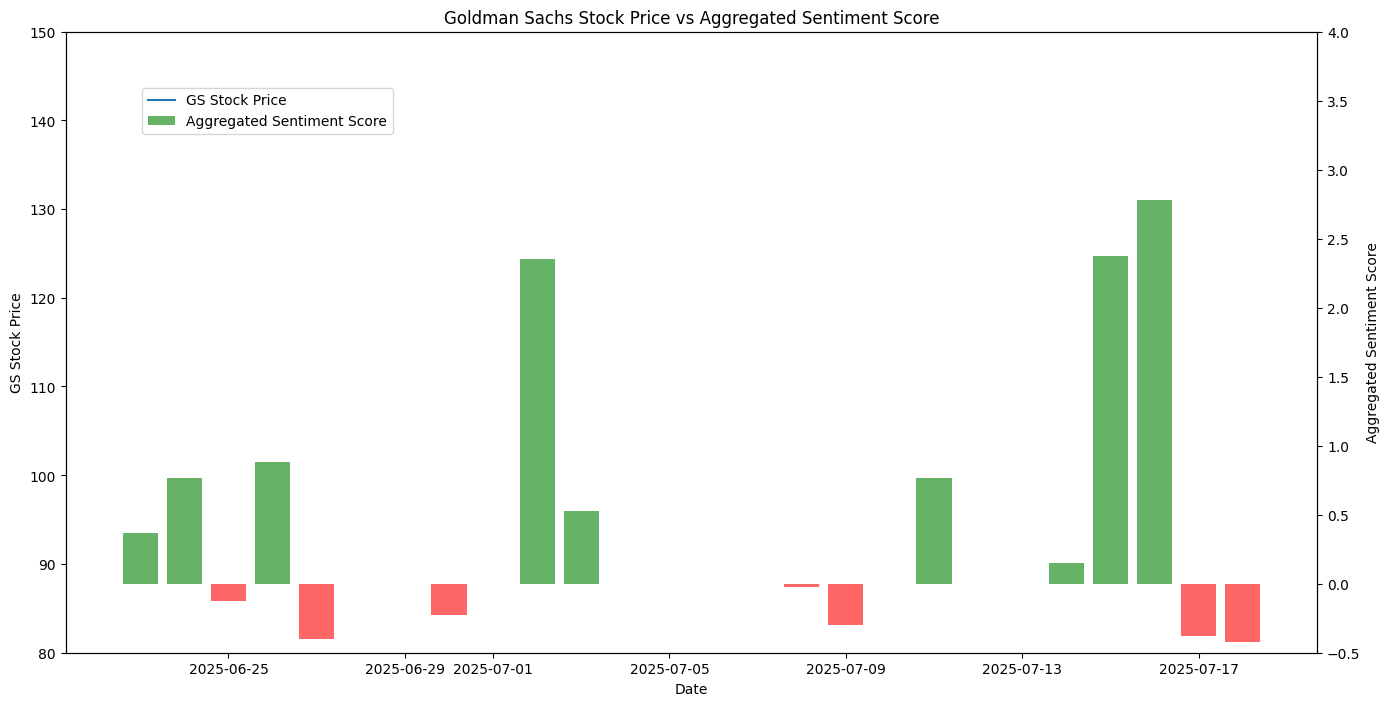

In [9]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    score = analyzer.polarity_scores(text)
    return score['compound']

news_data['sentiment_score'] = news_data['cleaned_headline'].apply(get_sentiment_score)

# Convert dates to datetime format
news_data['date'] = pd.to_datetime(news_data['date']).dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

# Aggregate sentiment scores by date
aggregated_sentiment = news_data.groupby('date')['sentiment_score'].sum().reset_index()

# Merge stock data with aggregated sentiment scores
combined_data = pd.merge(stock_data, aggregated_sentiment, left_on='Date', right_on='date', how='inner')

# Visualize the data with a secondary y-axis and bar plot for aggregated sentiment scores
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('GS Stock Price')
ax1.plot(combined_data['Date'], combined_data['Close'], label='GS Stock Price')
ax1.tick_params(axis='y')
ax1.set_ylim(80, 150)  # Set the left y-axis range

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Aggregated Sentiment Score')

# Use different colors for positive and negative bar values
colors = ['green' if val >= 0 else 'red' for val in combined_data['sentiment_score']]
ax2.bar(combined_data['Date'], combined_data['sentiment_score'], label='Aggregated Sentiment Score', color=colors, alpha=0.6)
ax2.tick_params(axis='y')
ax2.set_ylim(-0.5, 4)  # Set the right y-axis range

fig.tight_layout()
plt.title('Goldman Sachs Stock Price vs Aggregated Sentiment Score')
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()